<a href="https://colab.research.google.com/github/evan-grinalds/Unit-2-Build/blob/master/notebooks/Unit_2_Build_Tesla.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### EDA

In [ ]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/evan-grinalds/Unit-2-Build/master/data/'
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pdpbox
    !pip install shap

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [ ]:
import pandas as pd

df = pd.read_csv(DATA_PATH+'model_s.csv')

print(df.shape)
df

(200, 7)


,year,car,battery,ludacris_mode,all_wheel_drive,mileage,price
0,2013,Model S,60,No,No,82851 mi.,27995
1,2018,Model S,100,No,Yes,5357 mi.,57992
2,2012,Model S,60,No,No,85478 mi.,24499
3,2017,Model S,100,No,Yes,32593 mi.,59980
4,2016,Model S,60,No,Yes,28418 mi.,49560
...,...,...,...,...,...,...,...
195,2014,Model S,60,No,No,25444 mi.,39590
196,2016,Model S,100,Yes,Yes,33719 mi.,67990
197,2020,Model S,100,No,No,1527 mi.,83900
198,2016,Model S,75,No,No,50600 mi.,40500


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Read train_features.csv
train = pd.read_csv(DATA_PATH+'training.csv')
                
# Read test_features.csv
test = pd.read_csv(DATA_PATH+'test.csv')

# Split train into train & val
train, val = train_test_split(train, train_size=0.80, test_size=0.20) 

In [ ]:
# Remove symbols, convert to integer
train['mileage'] = (
train['mileage']
.str.replace('mi.','')
.astype(int)
)

val['mileage'] = (
val['mileage']
.str.replace('mi.','')
.astype(int)
)

test['mileage'] = (
test['mileage']
.str.replace('mi.','')
.astype(int)
)

df['mileage'] = (
df['mileage']
.str.replace('mi.','')
.astype(int)
)

In [ ]:
import plotly.express as px
px.scatter(df, x='year', y='price', trendline='ols')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [ ]:
# Arrange data into X features matrix and y target vector
features = ['year', 'battery', 'ludacris_mode', 'all_wheel_drive', 'mileage']
target = 'price'
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [ ]:
# Check shape before encoding
X_train.shape, X_val.shape, X_test.shape

((79, 5), (20, 5), (100, 5))

In [ ]:
import category_encoders as ce

encoder = ce.OneHotEncoder(use_cat_names=True)
X_train = encoder.fit_transform(X_train)
X_val = encoder.transform(X_val)
X_test = encoder.transform(X_test)

In [ ]:
# Check shape after encoding
X_train.shape, X_val.shape, X_test.shape

((79, 7), (20, 7), (100, 7))

In [ ]:
X_train.head()

,year,battery,ludacris_mode_Yes,ludacris_mode_No,all_wheel_drive_Yes,all_wheel_drive_No,mileage
68,2016,90,1,0,1,0,20279
64,2013,60,0,1,0,1,52802
76,2014,60,1,0,0,1,35482
80,2016,70,0,1,0,1,70300
11,2015,85,0,1,1,0,28017


### Baseline

In [ ]:
pd.options.display.float_format = '{:,.0f}'.format
df['price'].describe()

count      200
mean    47,691
std     15,380
min     24,499
25%     35,000
50%     44,585
75%     57,247
max     92,900
Name: price, dtype: float64

In [ ]:
guess = df['price'].mean()

In [ ]:
guess

47690.6

In [ ]:
errors = guess - df['price']

In [ ]:
errors

0      19,696
1     -10,301
2      23,192
3     -12,289
4      -1,869
        ...  
195     8,101
196   -20,299
197   -36,209
198     7,191
199     7,791
Name: price, Length: 200, dtype: float64

In [ ]:
mean_absolute_error = errors.abs().mean()

In [ ]:
print(f'If we guessed every Tesla Model S sold for ${guess:,.0f},')
print(f'we would be off by ${mean_absolute_error:,.0f} on average.')

If we guessed every Tesla Model S sold for $47,691,
we would be off by $12,357 on average.


### Linear Model

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
# Training 
y_pred_train = model.predict(X_train)
print("MAE(Train):$", mean_absolute_error(y_train, y_pred_train))

MAE(Train):$ 4748.901040160663


In [ ]:
r2_base = r2_score(y_train, y_pred_train)
print('R^2 scores (Train):',r2_base)

R^2 scores (Train): 0.8170828654063889


In [ ]:
# Validation
y_pred_val = model.predict(X_val)
print("MAE(Val):$",mean_absolute_error(y_val, y_pred_val))

MAE(Val):$ 7598.258684752975


In [ ]:
r2_base = r2_score(y_val, y_pred_val)
print('r^2 scores (Val):',r2_base)

r^2 scores (Val): 0.7537741142443279


### Predict the car value

In [ ]:
model.coef_

array([ 3.69485997e+03,  4.47052804e+02,  3.30573491e+03, -3.30573491e+03,
       -8.26962919e+02,  8.26962919e+02, -1.42418608e-01])

In [ ]:
list(X_train)

['year',
 'battery',
 'ludacris_mode_Yes',
 'ludacris_mode_No',
 'all_wheel_drive_Yes',
 'all_wheel_drive_No',
 'mileage']

In [ ]:
# Predict the price of the Tesla Model S
year = 2016
battery = 90
ludacris_mode_No = 0
ludacris_mode_Yes = 1
all_wheel_drive_Yes = 1
all_wheel_drive_No = 0
mileage = 30000

In [ ]:
price = model.predict([[year, battery, ludacris_mode_No, ludacris_mode_Yes, all_wheel_drive_Yes, all_wheel_drive_No, mileage]])

In [ ]:
print("This Tesla Model S should be price at :$",price)

This Tesla Model S should be price at :$ [54515.24508374]


### Ridge Regression

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import category_encoders as ce
import numpy as np
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.impute import KNNImputer
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipeline = make_pipeline(
    ce.BinaryEncoder(), 
    KNNImputer(), 
    StandardScaler(), 
    SelectKBest(f_regression), 
    Ridge()
)

param_distributions = {
    'knnimputer__n_neighbors': [3,4,5,6,7,8], 
    'selectkbest__k': range(1, len(X_train.columns)+1), 
    'ridge__alpha': [0.1, 1,8,9,10,15], 
}

# If you're on Colab, decrease n_iter & cv parameters
search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=100, 
    cv=10, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train);

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1774s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0770s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1023s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 248 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 336 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 440 tasks      | elapsed:  

In [ ]:
print('Ridge Regression MAE: $', -search.best_score_)

Ridge Regression MAE: $ 5064.80981819659


### Random Forest

In [ ]:
from scipy.stats import randint, uniform
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
pipeline = make_pipeline(
    ce.TargetEncoder(), 
    SimpleImputer(),
    StandardScaler(), 
    RandomForestRegressor(random_state=42)
)

param_distributions = {
    'targetencoder__min_samples_leaf': randint(1, 1000),     
    'simpleimputer__strategy': ['mean', 'median'], 
    'randomforestregressor__n_estimators': randint(50, 500), 
    'randomforestregressor__max_depth': [5, 10, 15, 20, None], 
    'randomforestregressor__max_features': uniform(0, 1), 
}

# If you're on Colab, decrease n_iter & cv parameters
search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=100, 
    cv=10, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train);

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:   37.2s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   46.2s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   53.3s
[Paralle

In [ ]:
print('Random Forest MAE: $', -search.best_score_)

Random Forest MAE: $ 3801.4456003039522


### XGBoost

In [ ]:
from xgboost import XGBRegressor
pipeline = make_pipeline(
    ce.TargetEncoder(), 
    SimpleImputer(),
    StandardScaler(), 
    XGBRegressor(random_state=42,n_jobs=-1)
)
param_distributions = {
    'targetencoder__min_samples_leaf': randint(1, 1000),     
    'simpleimputer__strategy': ['mean', 'median'],
    'xgbregressor__learning_rate': [.03, 0.05, .07 ,0.13,0.2],
    'xgbregressor__max_depth': [5, 6, 7],}

# If you're on Colab, decrease n_iter & cv parameters
search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=100, 
    cv=10, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)
search.fit(X_train, y_train);

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1754s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1399s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 356 tasks      | elapsed:    8.0s
[Parallel(n_jo

[17:52:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   22.2s finished


In [ ]:
print('XG Boost MAE:', -search.best_score_)

XG Boost MAE: 4031.3970040457593


### Gradient Boost

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor


pipeline = make_pipeline(
    ce.TargetEncoder(), 
    SimpleImputer(),
    StandardScaler(), 
    GradientBoostingRegressor(random_state=42)
)
param_distributions = {
    'targetencoder__min_samples_leaf': randint(1, 1000),     
    'simpleimputer__strategy': ['mean', 'median'], 
    'gradientboostingregressor__max_depth': [5, 10, 15, 20, None], 
    'gradientboostingregressor__loss': ['ls','lad','huber','quantile'], 
}

# If you're on Colab, decrease n_iter & cv parameters
search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=100, 
    cv=10, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)
search.fit(X_train, y_train);

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1032s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Batch computation too slow (2.4804s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   36.9s
[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done 108 tasks      | elapsed:   42.6s
[Parallel(n_jo

In [ ]:
print('Gradient Boost MAE:', -search.best_score_)

Gradient Boost MAE: 4034.188357670008


### Permutation Importances

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=20, 
                           random_state=42, 
                           n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train);

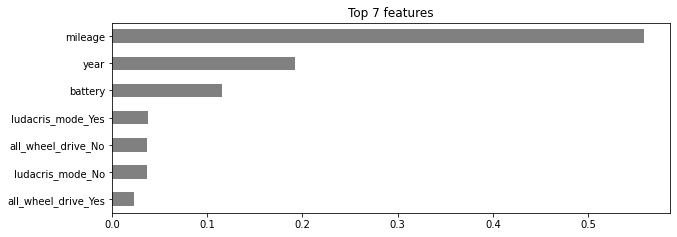

In [ ]:
# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 7
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

### Partial Dependence Plot 1 feature

In [ ]:
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

gb = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBRegressor(n_estimators=200, objective='reg:squarederror', n_jobs=-1)
)

gb.fit(X_train, y_train)
y_pred = gb.predict(X_val)
print('Gradient Boosting R^2', r2_score(y_val, y_pred))

Gradient Boosting R^2 0.7844840161551091


In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72

In [ ]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'mileage'

isolated = pdp_isolate(
      model=gb,
      dataset=X_val,
      model_features=X_val.columns,
      feature=feature
)

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f0d09cd56a0>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f0d09d192e8>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


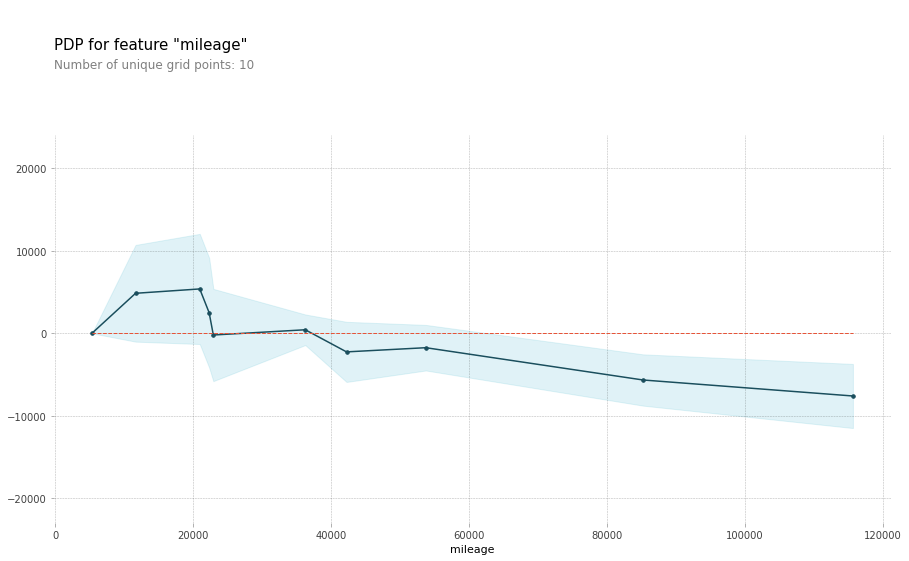

In [ ]:
pdp_plot(isolated, feature_name=feature)

### Partial Dependence Plot 2 features

In [ ]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['year', 'mileage']

interaction = pdp_interact(
    model=gb,
    dataset=X_val,
    model_features=X_val.columns,
    features=features
)

In [ ]:
pdp_interact_plot

<function pdpbox.pdp.pdp_interact_plot>

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


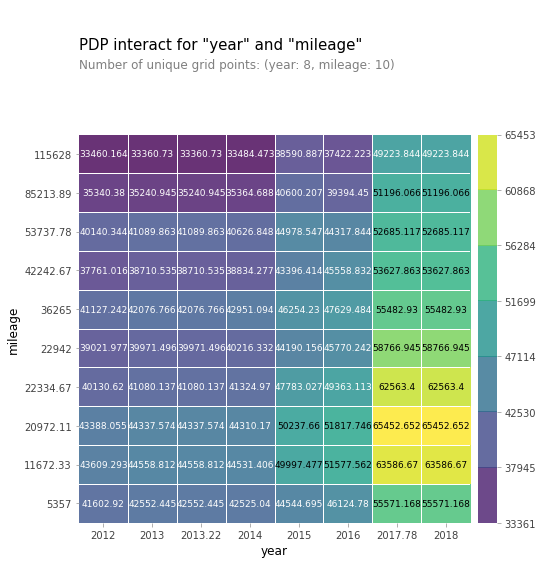

In [ ]:
pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

### Shapley force plot 

In [ ]:
# Assign to X, y
features = ['year', 'battery', 'ludacris_mode', 'all_wheel_drive', 'mileage']
target = ['price']

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [ ]:
import category_encoders as ce

encoder = ce.OneHotEncoder(use_cat_names=True)
X_train = encoder.fit_transform(X_train)
X_val = encoder.transform(X_val)
X_test = encoder.transform(X_test)

In [ ]:
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

param_distributions = { 
    'n_estimators': randint(50, 500), 
    'max_depth': [5, 10, 15, 20, None], 
    'max_features': uniform(0, 1), 
}

search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42), 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=2, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=6, 
    random_state=42
)

search.fit(X_train, y_train);

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of  10 | elapsed:    2.2s remaining:    5.1s
[Parallel(n_jobs=6)]: Done   5 out of  10 | elapsed:    4.4s remaining:    4.4s
[Parallel(n_jobs=6)]: Done   7 out of  10 | elapsed:    4.8s remaining:    2.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    4.9s finished


In [ ]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation MAE', -search.best_score_)
model = search.best_estimator_

Best hyperparameters {'max_depth': 15, 'max_features': 0.020584494295802447, 'n_estimators': 307}
Cross-validation MAE 4654.764040967177


In [ ]:
# Get an individual observation to explain.
# For example, the 5th row from the test set.
row = X_train.iloc[[8]]
row

,year,battery,ludacris_mode_Yes,ludacris_mode_No,all_wheel_drive_Yes,all_wheel_drive_No,mileage
21,2015,85,1,0,1,0,54700


In [ ]:
# What was the actual price for this Model S?
y_test.iloc[[8]]

,price
8,29878


In [ ]:
# What does the model predict for this Model S?
model.predict(row)

array([47913.43648208])

In [ ]:
# Why did the model predict this?
# Look at a Shapley Values Force Plot
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row
)

### Visualizations

In [ ]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/evan-grinalds/Unit-2-Build/master/data/models3x.csv'

In [ ]:
import pandas as pd

df1 = pd.read_csv(DATA_PATH)

print(df1.shape)
df1

(600, 3)


,year,car,price
0,2013,Model S,27995
1,2018,Model S,57992
2,2012,Model S,24499
3,2017,Model S,59980
4,2016,Model S,49560
...,...,...,...
595,2018,Model X,119888
596,2018,Model X,71985
597,2016,Model X,95000
598,2019,Model X,84990


In [ ]:
import plotly.express as px
fig = px.scatter(df1, x="year", y="price", color="car")
fig.show()

In [ ]:
!pip install chart_studio
import chart_studio
import chart_studio.plotly as py
import chart_studio.tools as tls
username = 'egrinalds'
api_key = '79SFjg8dRm6qVccd3x9r'
chart_studio.tools.set_credentials_file(username=username, api_key=api_key)
py.plot(fig, filename = 'Tesla Vehicles', auto_open=True)